In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from timeit import default_timer as timer

plt.style.use('default')
fig_save_options = {'bbox_inches': 'tight', 'pad_inches': 0.1}

def measure(func, test_rounds=3):
    """A decorator wraps given function with timer.
    Returns:
        A wrapper that prepends the average execution time (ms) to the result.

    Reference:
        https://stackoverflow.com/a/25823885
    """
    def wrapper(*args, **kwargs):
        elapsed_time = 0
        start = timer()
        for i in range(test_rounds):
            result = func(*args, **kwargs)
        end = timer()
        return (end - start) * 1e3 / test_rounds, result
    return wrapper

def get_base_array(a):
    """Get the ndarray base which owns memory block."""
    if isinstance(a.base, np.ndarray):
        return get_base_array(a.base)
    return a

def share_base(a, b):
    return get_base_array(a) is get_base_array(b)


In [3]:
a = np.random.rand(6, 4)
print('Share base?')
print('-' * 50)
print('a, a[2:, 1:]       ->', share_base(a, a[2:, 1:]))
print('a, a[a> 0]         ->', share_base(a, a[a > 0]))
print('a, a.copy()        ->', share_base(a, a.copy()))
print('a, a + 2           ->', share_base(a, a + 2))
print('a, a.transpose()   ->', share_base(a, a.transpose()))
print('a, a.reshape(8, 3) ->', share_base(a, a.reshape(8, 3)))
print('a, a.ravel()       ->', share_base(a, a.ravel()))
print('a, a.flatten()     ->', share_base(a, a.flatten()))
print('a[::2], a[1::2]    ->', share_base(a[::2], a[1::2]), '(share_base)')
print('a[::2], a[1::2]    ->', np.shares_memory(a[::2], a[1::2]), '(np.shares_memory)')


Share base?
--------------------------------------------------
a, a[2:, 1:]       -> True
a, a[a> 0]         -> False
a, a.copy()        -> False
a, a + 2           -> False
a, a.transpose()   -> True
a, a.reshape(8, 3) -> True
a, a.ravel()       -> True
a, a.flatten()     -> False
a[::2], a[1::2]    -> True (share_base)
a[::2], a[1::2]    -> False (np.shares_memory)


In [4]:
@measure
def sum_elems_for_loops(A, row_major=True):
    """Calclate summation of matrix elements."""
    rows, cols = A.shape
    result = 0
    if row_major:
        for i in range(rows):
            for j in range(cols):
                result += A[i, j]
    else:
        for j in range(cols):
            for i in range(rows):
                result += A[i, j]
    return result

@measure
def sum_elems_vec_reduction(A, axis):
    return np.sum(np.sum(A, axis=axis))


In [5]:
row_major_times = []
col_major_times = []
row_vec_reduce_times = []
col_vec_reduce_times = []
matrix_sizes = []

for n in np.linspace(1000, 3300, 16, dtype=int):
    A = np.random.rand(n, n)
    print('Traversing a matrix of size {}'.format(A.shape))
    matrix_sizes.append(A.nbytes * 1e-6)
    row_major_times.append(sum_elems_for_loops(A, True)[0])
    row_vec_reduce_times.append(sum_elems_vec_reduction(A, 1)[0])
    
    col_major_times.append(sum_elems_for_loops(A, False)[0])
    col_vec_reduce_times.append(sum_elems_vec_reduction(A, 0)[0])


Traversing a matrix of size (1000, 1000)
Traversing a matrix of size (1153, 1153)
Traversing a matrix of size (1306, 1306)
Traversing a matrix of size (1460, 1460)
Traversing a matrix of size (1613, 1613)
Traversing a matrix of size (1766, 1766)
Traversing a matrix of size (1920, 1920)
Traversing a matrix of size (2073, 2073)
Traversing a matrix of size (2226, 2226)
Traversing a matrix of size (2380, 2380)
Traversing a matrix of size (2533, 2533)
Traversing a matrix of size (2686, 2686)
Traversing a matrix of size (2840, 2840)
Traversing a matrix of size (2993, 2993)
Traversing a matrix of size (3146, 3146)
Traversing a matrix of size (3300, 3300)


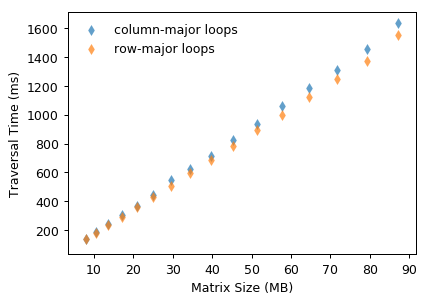

In [6]:
marker_style = {'alpha': 0.7, 'marker':'d', 'linewidths':0.1 }
plt.figure(figsize=(5, 3.5), dpi=90)
plt.xlabel('Matrix Size (MB)')
plt.ylabel('Traversal Time (ms)')
plt.scatter(matrix_sizes, col_major_times, label='column-major loops', **marker_style)
plt.scatter(matrix_sizes, row_major_times, label='row-major loops', **marker_style)
# plt.scatter(matrix_sizes, col_vec_reduce_times, label='column reduction', **marker_style)
# plt.scatter(matrix_sizes, row_vec_reduce_times, label='row reduction', **marker_style)
plt.legend(loc='upper left', frameon=False)
plt.savefig('traversal_perf_cmp.png', **fig_save_options)
plt.show()


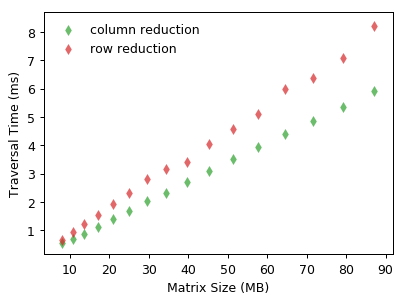

In [7]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

plt.figure(figsize=(5, 3.5), dpi=90)
plt.xlabel('Matrix Size (MB)')
plt.ylabel('Traversal Time (ms)')
plt.scatter(matrix_sizes, col_vec_reduce_times, label='column reduction', color=colors[2], **marker_style)
plt.scatter(matrix_sizes, row_vec_reduce_times, label='row reduction', color=colors[3], **marker_style)
plt.legend(loc='upper left', frameon=False)
plt.savefig('traversal_perf_cmp_vec_only.png', **fig_save_options)
plt.show()


In [8]:
@measure
def sum_elems_matrix_dot_reduction(A, axis):
    reduced_vec = None
    coeffs = np.ones(A.shape[1 - axis])
    if axis == 0:
        reduced_vec = A.dot(coeffs)
    else:
        reduced_vec = A.T.dot(coeffs)

    return np.sum(reduced_vec)

@measure
def sum_elems(A):
    return np.sum(A)



Summing a matrix of size (1000, 1000)
Summing a matrix of size (1210, 1210)
Summing a matrix of size (1421, 1421)
Summing a matrix of size (1631, 1631)
Summing a matrix of size (1842, 1842)
Summing a matrix of size (2052, 2052)
Summing a matrix of size (2263, 2263)
Summing a matrix of size (2473, 2473)
Summing a matrix of size (2684, 2684)
Summing a matrix of size (2894, 2894)
Summing a matrix of size (3105, 3105)
Summing a matrix of size (3315, 3315)
Summing a matrix of size (3526, 3526)
Summing a matrix of size (3736, 3736)
Summing a matrix of size (3947, 3947)
Summing a matrix of size (4157, 4157)
Summing a matrix of size (4368, 4368)
Summing a matrix of size (4578, 4578)
Summing a matrix of size (4789, 4789)
Summing a matrix of size (5000, 5000)
Summing a matrix of size (1000, 1000)
Summing a matrix of size (1210, 1210)
Summing a matrix of size (1421, 1421)
Summing a matrix of size (1631, 1631)
Summing a matrix of size (1842, 1842)
Summing a matrix of size (2052, 2052)
Summing a ma

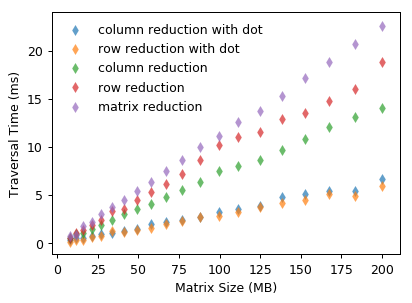

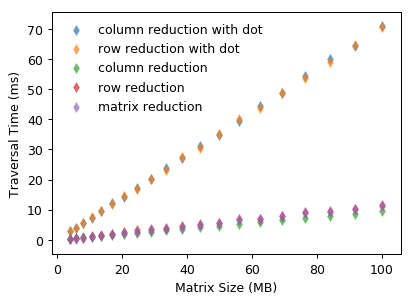

In [9]:
def plot_various_reductions(dtype, filename):
    sample_range = np.linspace(1000, 5000, 20, dtype=int)
    sample_times = np.empty((5, len(sample_range)))
    matrix_sizes = []

    for idx, n in enumerate(sample_range):
        A = np.random.rand(n, n).astype(dtype)
        print('Summing a matrix of size {}'.format(A.shape))
        matrix_sizes.append(A.nbytes * 1e-6)
        sample_times[0, idx], r1 = sum_elems_matrix_dot_reduction(A, 1)  # Reduce columns first
        sample_times[1, idx], r1 = sum_elems_matrix_dot_reduction(A, 0)  # Reduce rows first
        sample_times[2, idx], r1 = sum_elems_vec_reduction(A, 0)     # Reduce columns first
        sample_times[3, idx], r0 = sum_elems_vec_reduction(A, 1)     # Reduce rows first
        sample_times[4, idx], r2 = sum_elems(A)  # Reduce element-wise

    plt.figure(figsize=(5, 3.5), dpi=90)
    plt.xlabel('Matrix Size (MB)')
    plt.ylabel('Traversal Time (ms)')
    labels = ['column reduction with dot', 'row reduction with dot',
            'column reduction', 'row reduction',
            'matrix reduction']
    for i in range(sample_times.shape[0]):
        plt.scatter(matrix_sizes, sample_times[i], label=labels[i], **marker_style)
    plt.legend(loc='upper left', frameon=False)
    plt.savefig(filename, **fig_save_options)

plot_various_reductions(np.float64, 'traversal_perf_various_reductions_float64.png')
plot_various_reductions(np.float32, 'traversal_perf_various_reductions_float32.png')


0.09178066666019428 0.04863999999808281
0.4817533333323354 0.21295366666625645
1.475221666661734 0.5420556666706489
2.6600260000009257 1.0752933333340782
4.197919999995747 1.4217459999959676
6.43014199999925 2.733981333335578
8.630031999994495 3.301731333332706
11.388570333328593 4.826257000000093
16.375727666674795 6.045004666674458
21.21620699999956 8.263384000002816
25.61456499999319 9.489621999999068
31.14956166666616 11.110479000005094
37.412450666664654 13.058920666670323
46.80649933333333 14.737993666670945
55.94066133333323 17.52014100000565
60.3184446666584 20.44460500000393
69.2203103333308 21.814866666668802
74.82215133332677 25.699518999999782
86.72509133333506 27.223664999998693
93.40857833333871 32.37665300000003


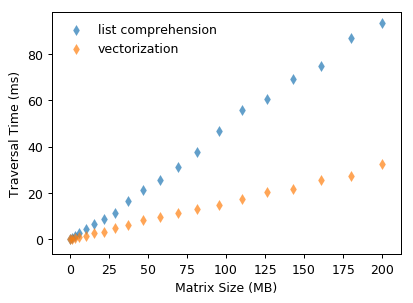

In [10]:
@measure
def power(a, e):
    return [x ** e for x in a]

@measure
def power_vec(a, e):
    return a ** e

matrix_sizes = []
power_times = []
vec_power_times = []
for n in np.linspace(100, 5000, 20, dtype=int):
    A = np.random.rand(n, n)
    matrix_sizes.append(A.nbytes * 1e-6)
    t1, _ = power(A, 2.0)
    t2, _ = power_vec(A, 2.0)
    power_times.append(t1)
    vec_power_times.append(t2)
    print(t1, t2)

plt.figure(figsize=(5, 3.5), dpi=90)
plt.xlabel('Matrix Size (MB)')
plt.ylabel('Traversal Time (ms)')
plt.scatter(matrix_sizes, power_times, label='list comprehension', **marker_style)
plt.scatter(matrix_sizes, vec_power_times, label='vectorization', **marker_style)
plt.legend(loc='upper left', frameon=False)


In [11]:
# Three implementations of computing Euclidean distance between two dataset X, Y.
# Where X is MX by N matrix, Y is MY by N matrix.
@measure
def norm_two_loop(X, Y):
    dists = np.empty((X.shape[0], Y.shape[0]))
    for i in range(X.shape[0]):
        for j in range(Y.shape[0]):
            # The memory usagee is two (N,) vectors.
            dists[i, j] = np.sqrt(np.sum((X[i] - Y[j]) ** 2))
    return dists

@measure
def norm_one_loop(X, Y):
    dists = np.empty((X.shape[0], Y.shape[0]))
    for i in range(X.shape[0]):
        # The memory usage here is (N,) plus (MY, N) from Y.
        dists[i, :] = np.sqrt(np.sum((X[i] - Y) ** 2, axis=1))
    return dists

@measure
def norm_no_loop(X, Y):
    X_sqr = np.sum(X ** 2, axis=1)  # X_sqr.shape = (MX,)
    Y_sqr = np.sum(Y ** 2, axis=1)  # Y_sqr.shape = (MY,)
    # X.dot(Y.T) takes two 1D vectors in its implicit loop on at a time.
    # The shapes of entire broadcasting process are: (MX, 1) - (MX, MY) + (MY,)
    # => (MX, MY) + (MY)
    dists = np.sqrt(X_sqr[:, np.newaxis] - 2.0 * X.dot(Y.T) + Y_sqr)
    return dists


In [12]:
def plot_broadcasting_costs(col_size, y_sample_range):
    sample_rounds = len(y_sample_range)
    ts = np.empty((3, sample_rounds))
    data_sizes = np.empty(sample_rounds)

    X = np.random.randn(500, col_size)

    for idx, y in enumerate(y_sample_range):
        Ys = np.random.randn(y, col_size)
        ts[2, idx], r1 = norm_two_loop(X, Ys)

        Ys = np.random.randn(y, col_size)  # Create new data of Y to avoid cache hit
        ts[1, idx], r2 = norm_one_loop(X, Ys)

        Ys = np.random.randn(y, col_size)  # Create new data of Y to avoid cache hit
        ts[0, idx], r3 = norm_no_loop(X, Ys)

        data_sizes[idx] = Ys.nbytes * 1e-6
        # print('Processing with Y {} ({:04.3f} MB), elapsed time: {}'.format(Ys.shape, data_sizes[idx], ts[idx]))
        print('Processing {}'.format(y))

    plt.title('X shape {}, Y shape {}~{}'.format(X.shape, (y_sample_range[0], col_size), (y_sample_range[-1], col_size)))
    plt.xlabel('Size of Matrix Y (MB)')
    plt.ylabel('Computation Time (ms)')
    plt.scatter(data_sizes, ts[2], marker='^', alpha=0.7, label='two loops')
    plt.scatter(data_sizes, ts[1], marker='d', alpha=0.7, label='one loop')
    plt.scatter(data_sizes, ts[0], marker='o', alpha=0.7, label='no loop')
    plt.legend(loc='upper left', frameon=False)


Processing 10
Processing 13
Processing 16
Processing 20
Processing 23
Processing 26
Processing 30
Processing 33
Processing 36
Processing 40
Processing 43
Processing 46
Processing 50
Processing 53
Processing 56
Processing 60


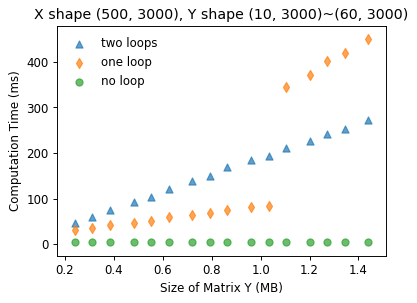

In [13]:
# Process with wide Y
plt.figure(figsize=(5, 3.5), dpi=85)
plot_broadcasting_costs(3000, np.linspace(10, 60, 16, dtype=int))
plt.savefig('L2_perf_cmp_wide_y.png', **fig_save_options)


Processing 30
Processing 40
Processing 50
Processing 60
Processing 70
Processing 80
Processing 90
Processing 100
Processing 110
Processing 120
Processing 130
Processing 140
Processing 150
Processing 160
Processing 170
Processing 180


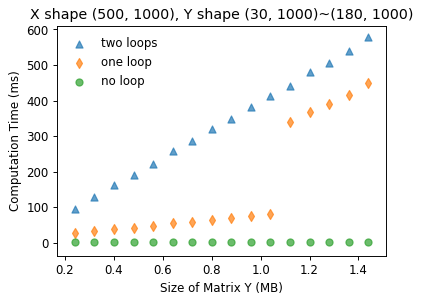

In [14]:
# Process with tall Y
plt.figure(figsize=(5, 3.5), dpi=85)
plot_broadcasting_costs(1000, np.linspace(30, 180, 16, dtype=int))
plt.savefig('L2_perf_cmp_tall_y.png', **fig_save_options)